In [1]:
from tqdm.notebook import  tqdm
import seaborn as sns; sns.set()
import pickle as pkl
from pathlib import Path
import pandas as pd
from functools import partial 

sns.set(rc={'figure.figsize':(15, 6)})

In [3]:
class Thresholdout:
    def __init__(self, train, holdout, tolerance=0.01/4, scale_factor=4, keep_log=True):
        self.tolerance = tolerance
        
        self.laplace_eps = Laplace(torch.tensor([0.0]), torch.tensor([2*self.tolerance]))
        self.laplace_gamma = Laplace(torch.tensor([0.0]), torch.tensor([4*self.tolerance]))
        self.laplace_eta = Laplace(torch.tensor([0.0]), torch.tensor([8*self.tolerance]))

        self.train = train
        self.holdout = holdout
        
        self.T = 4*tolerance + self.noise(self.laplace_gamma)
        # self.budget = ???
        
        self.keep_log = keep_log
        if keep_log:
            self.log = pd.DataFrame(columns=['GlobStep', 'threshold', 'delta', 'phi_train', 'phi_holdout', 'estimate', 'overfit'])
        
        
    def noise(self, dist):
        return dist.sample().item()
        
    def verify_statistic(self, phi, glob_step=None):
        """
            - phi(dataset) -> statistic: 
              function returns the average of some statistic
        """
        
        train_val = phi(self.train)
        holdout_val = phi(self.holdout)
                
        delta = abs(train_val - holdout_val)
        thresh = self.T + self.noise(self.laplace_eta)
        
        if delta > thresh:
            self.T += self.noise(self.laplace_gamma)
            estimate = holdout_val + self.noise(self.laplace_eps)
        else:
            estimate = train_val
            
        if self.keep_log:
            if glob_step is None: 
                raise ValueException('please provide glob step if logging is on')
            self.log.loc[len(self.log)] = [glob_step, thresh, delta, train_val, holdout_val, estimate, delta > thresh]
            
        return estimate

## Importing Pickled Data

In [4]:
with open('./resnet-outcome.pkl','rb') as fp:
    resnet_loss, resnet_tout = pkl.load(fp)

In [6]:
with open('./conv-net-outcome.pkl','rb') as fp:
    convnet_loss, convnet_tout = pkl.load(fp)

In [7]:
convdf = convnet_tout.log

In [13]:
convdf['loss'] = [convnet_loss[i] for i in convdf['GlobStep'].tolist()]

## Simple Conv Net

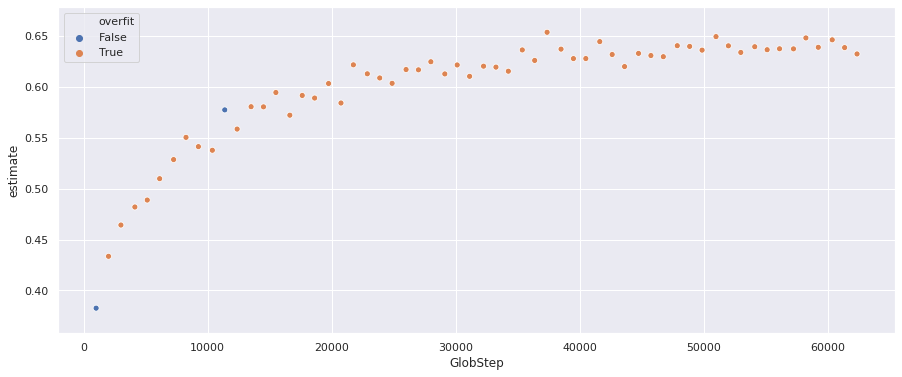

In [17]:
sns.scatterplot(data=convdf, x='GlobStep', y='estimate', hue='overfit')

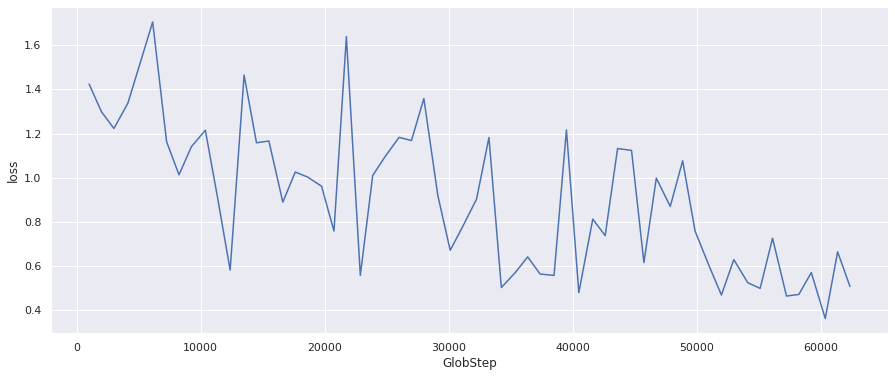

In [19]:
sns.lineplot(data=convdf, x='GlobStep', y='loss')

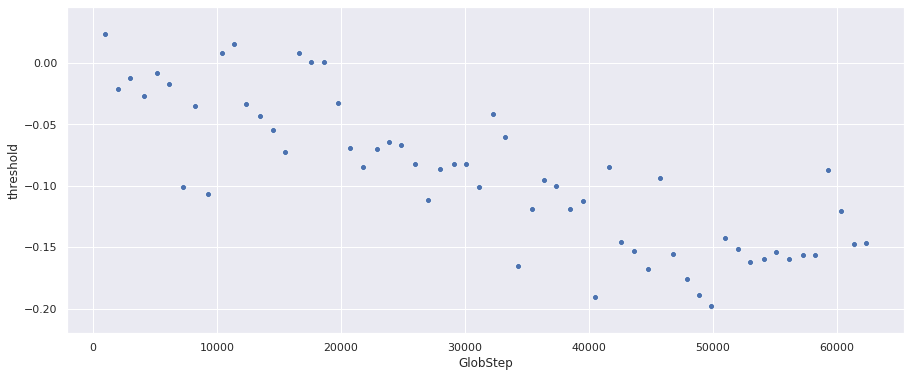

In [23]:
sns.scatterplot(data=convdf, x='GlobStep', y='threshold')

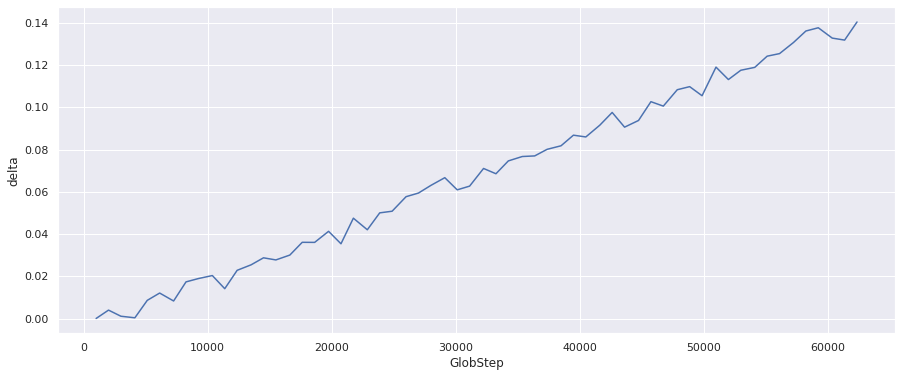

In [52]:
sns.lineplot(data=convdf, x='GlobStep', y='delta')

## ResNet Plots

In [24]:
resnetdf = resnet_tout.log

In [25]:
resnetdf['loss'] = [resnet_loss[i] for i in resnetdf['GlobStep'].tolist()]

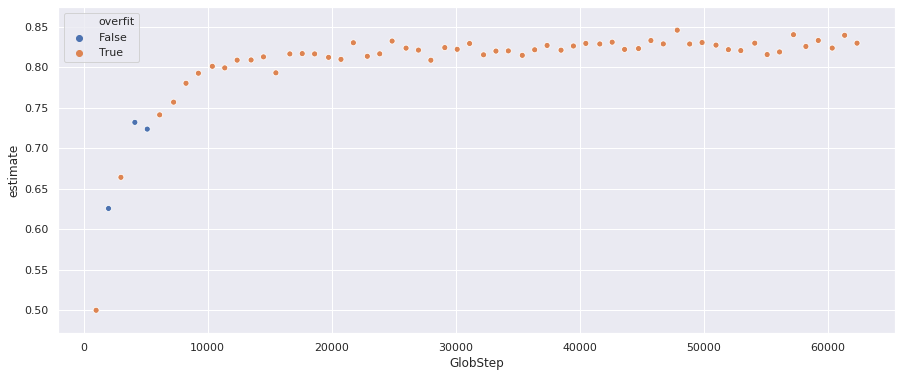

In [26]:
sns.scatterplot(data=resnetdf, x='GlobStep', y='estimate', hue='overfit')

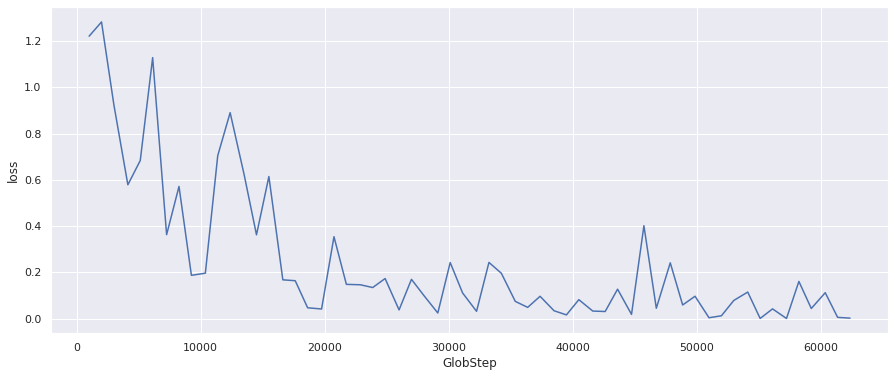

In [28]:
sns.lineplot(data=resnetdf, x='GlobStep', y='loss')

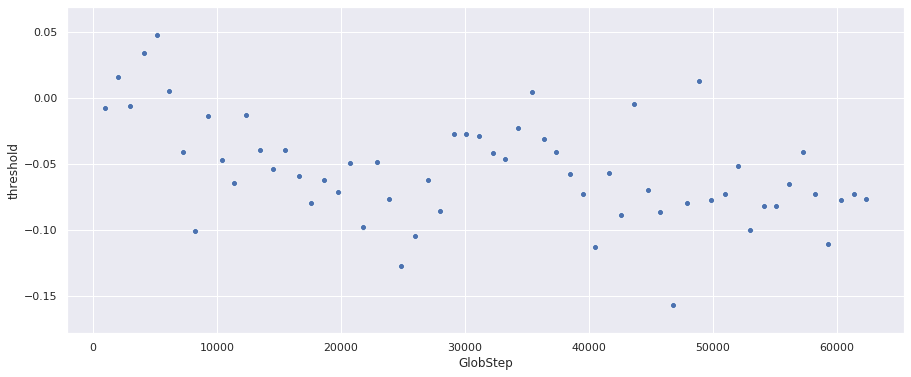

In [29]:
sns.scatterplot(data=resnetdf, x='GlobStep', y='threshold')

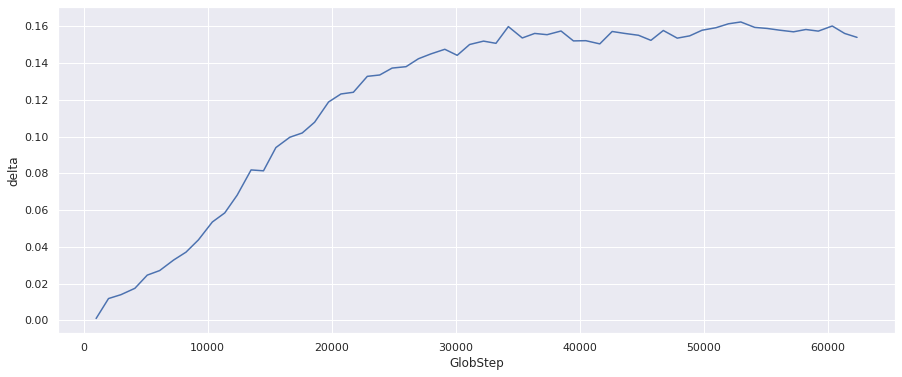

In [30]:
sns.lineplot(data=resnetdf, x='GlobStep', y='delta')

## LR Experiment

In [31]:
with open('./convnet-lr-outcome.pkl','rb') as fp:
    lrexp = pkl.load(fp)

In [60]:
lrexp.keys()

dict_keys([0.0003, 0.0006000000000000001, 0.0009, 0.0012000000000000001, 0.0015, 0.0018, 0.0021000000000000003, 0.0024000000000000002, 0.0027, 0.003])

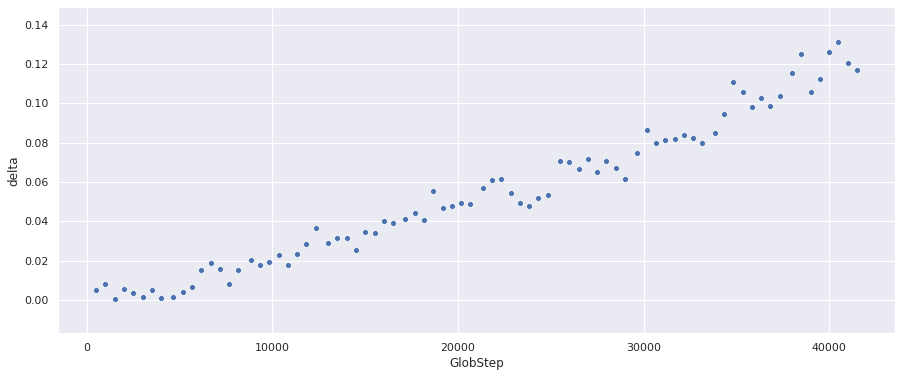

In [63]:
sns.scatterplot(data=lrexp[0.0012000000000000001][1].log, x='GlobStep', y='delta')

In [53]:
lrexp.keys()

dict_keys([0.0003, 0.0006000000000000001, 0.0009, 0.0012000000000000001, 0.0015, 0.0018, 0.0021000000000000003, 0.0024000000000000002, 0.0027, 0.003])

In [38]:
lrexp[0.0003][1].log['overfit'].sum()

75

In [39]:
len(lrexp[0.0003][1].log)

80

In [64]:
newd = {}
for i, (k,v) in enumerate(lrexp.items()):
    newd[i] = v[1].log['estimate'].tolist()[-1]

In [65]:
newd

{0: 0.6245160405518021,
 1: 0.600885325140087,
 2: 0.5684131754621863,
 3: 0.5551848701041192,
 4: 0.5657438826985657,
 5: 0.5066202298017218,
 6: 0.5357588594179601,
 7: 0.5415,
 8: 0.50414,
 9: 0.38104}

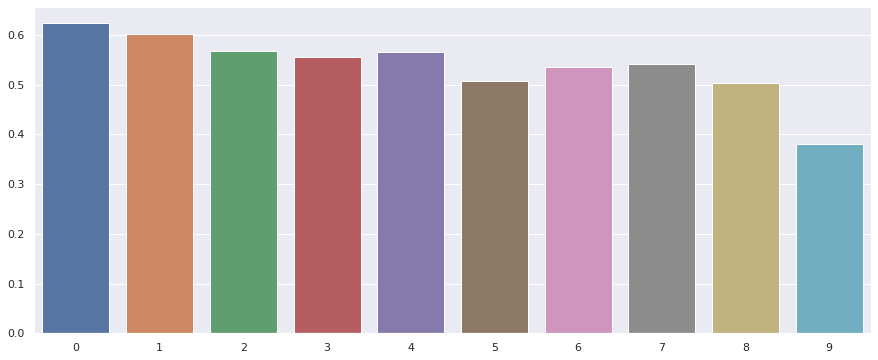

In [66]:
sns.barplot(x=list(newd.keys()),y=list(newd.values()))